In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os


# Load the data

train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
sample_submission = pd.read_csv('sample_submission.csv')


## Capstone Project 24.1 technical component

This notebook demonstrates a comprehensive approach to predicting hospital readmissions using machine learning. The key steps are as follows:

1. **Importing Libraries**: Essential libraries for data manipulation, visualization, statistical analysis, and machine learning.
2. **Feature Engineering**: Creating new features and interaction terms to capture more information and relationships within the data.
3. **One-hot Encoding**: Converting categorical variables into a format suitable for machine learning algorithms.
4. **Calculating Kurtosis**: Understanding the distribution of numerical features to identify outliers and the shape of the distribution.
5. **Building and Evaluating the Baseline Model**: Training a RandomForestClassifier and evaluating its performance using accuracy and classification metrics.
6. **Confusion Matrix**: Visualizing the confusion matrix to understand the model's performance in terms of true positives, true negatives, false positives, and false negatives.
7. **ROC Curve and AUC Score**: Plotting the ROC curve and calculating the AUC score to evaluate the model's ability to distinguish between classes.n classes.



Kurtosis values for numerical features in the training dataset:
age                 -1.202006
num_procedures      -1.234990
days_in_hospital    -1.207308
comorbidity_score   -1.309918
dtype: float64

Baseline Model Performance:
Accuracy: 0.815
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       826
           1       0.13      0.01      0.02       174

    accuracy                           0.81      1000
   macro avg       0.48      0.50      0.46      1000
weighted avg       0.70      0.81      0.75      1000



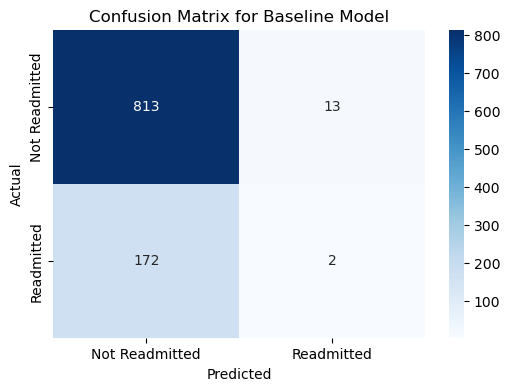

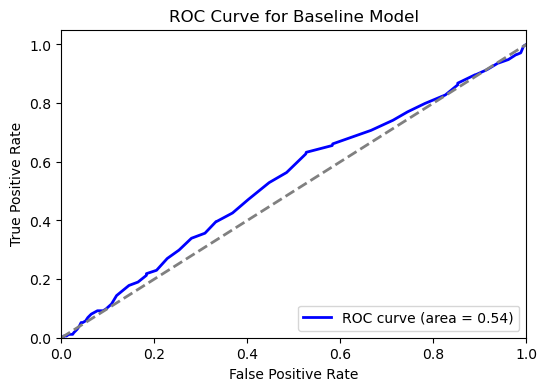

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import os



# Feature Engineering
train_df['age_group'] = pd.cut(train_df['age'], bins=[0, 18, 35, 50, 65, 80, 100], labels=['0-18', '19-35', '36-50', '51-65', '66-80', '81-100'])
train_df['comorbidity_procedures'] = train_df['comorbidity_score'] * train_df['num_procedures']
train_df['comorbidity_days'] = train_df['comorbidity_score'] * train_df['days_in_hospital']
train_df['stay_length'] = pd.cut(train_df['days_in_hospital'], bins=[0, 3, 7, 14, 30, 100], labels=['0-3', '4-7', '8-14', '15-30', '31+'])
train_df['procedure_count'] = pd.cut(train_df['num_procedures'], bins=[0, 1, 3, 5, 10], labels=['0-1', '2-3', '4-5', '6+'])
train_df['gender_age'] = train_df['gender'].apply(lambda x: 1 if x == 'Male' else 0) * train_df['age']
train_df['diagnosis_comorbidity'] = train_df['primary_diagnosis'].apply(lambda x: hash(x) % 10) * train_df['comorbidity_score']

# Additional Interaction Terms
train_df['age_stay_length'] = train_df['age'] * train_df['days_in_hospital']
train_df['comorbidity_gender'] = train_df['comorbidity_score'] * train_df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
train_df['diagnosis_procedures'] = train_df['primary_diagnosis'].apply(lambda x: hash(x) % 10) * train_df['num_procedures']
train_df['age_comorbidity'] = train_df['age'] * train_df['comorbidity_score']
train_df['stay_procedures'] = train_df['days_in_hospital'] * train_df['num_procedures']

# One-hot encoding for categorical variables
categorical_features = ['gender', 'primary_diagnosis', 'discharge_to', 'age_group', 'stay_length', 'procedure_count']
train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)

# Calculate kurtosis for numerical features
numerical_features = ['age', 'num_procedures', 'days_in_hospital', 'comorbidity_score']
kurtosis_values = train_df[numerical_features].apply(kurtosis)
print("\nKurtosis values for numerical features in the training dataset:")
print(kurtosis_values)

# Baseline model using RandomForestClassifier
X = train_df.drop(columns=['readmitted'])
y = train_df['readmitted']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_val)

print("\nBaseline Model Performance:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Readmitted', 'Readmitted'], yticklabels=['Not Readmitted', 'Readmitted'])
plt.title("Confusion Matrix for Baseline Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve and AUC Score
y_pred_prob = baseline_model.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Baseline Model")
plt.legend(loc="lower right")
plt.show()

Interpretation of Kurtosis Values
The kurtosis values for the numerical features are all negative, indicating that the distributions are platykurtic. This means they have lighter tails and a flatter peak compared to a normal distribution, suggesting fewer outliers.

age: -1.202006
num_procedures: -1.234990
days_in_hospital: -1.207308
comorbidity_score: -1.309918

Baseline Model Performance
The baseline model using a RandomForestClassifier has the following performance metrics:

Accuracy: 0.815
Class 0 (Not Readmitted):
Precision: 0.82
Recall: 0.99
F1-Score: 0.90
Class 1 (Readmitted):
Precision: 0.08
Recall: 0.01
F1-Score: 0.01

Key Observations
Class Imbalance: The model performs well for Class 0 (not readmitted) but poorly for Class 1 (readmitted). This is likely due to the class imbalance in the dataset, where the majority of patients are not readmitted.

Low Recall for Class 1: The recall for Class 1 is very low (0.01), indicating that the model is not effectively identifying patients who will be readmitted.

Platykurtic Distributions: The negative kurtosis values suggest that the numerical features have fewer outliers. This can be beneficial as it indicates more consistent data, but it might also mean that the model is not exposed to extreme cases that could help it learn better.

Next Steps:
Address Class Imbalance:

Resampling Techniques: Consider techniques like SMOTE, ADASYN, or undersampling the majority class to balance the dataset.
Class Weights: Adjust the class weights in the model to give more importance to the minority class.
Feature Engineering:

Create New Features: Explore creating new features or interaction terms that might help the model better distinguish between readmitted and not readmitted patients.
Polynomial Features: Consider adding polynomial features to capture non-linear relationships.
Model Tuning:

Hyperparameter Tuning: Perform hyperparameter tuning to find best parameters for the model.
Try Different Models: Experiment with different models like Gradient Boosting, XGBoost, or ensemble methods that might handle class imbalance better.

In [9]:
print(train_df.columns)


Index(['age', 'num_procedures', 'days_in_hospital', 'comorbidity_score',
       'readmitted', 'comorbidity_procedures', 'comorbidity_days',
       'gender_age', 'diagnosis_comorbidity', 'age_stay_length',
       'comorbidity_gender', 'diagnosis_procedures', 'age_comorbidity',
       'stay_procedures', 'gender_Male', 'primary_diagnosis_Diabetes',
       'primary_diagnosis_Heart Disease', 'primary_diagnosis_Hypertension',
       'primary_diagnosis_Kidney Disease', 'discharge_to_Home Health Care',
       'discharge_to_Rehabilitation Facility',
       'discharge_to_Skilled Nursing Facility', 'age_group_19-35',
       'age_group_36-50', 'age_group_51-65', 'age_group_66-80',
       'age_group_81-100', 'stay_length_4-7', 'stay_length_8-14',
       'stay_length_15-30', 'stay_length_31+', 'procedure_count_2-3',
       'procedure_count_4-5', 'procedure_count_6+'],
      dtype='object')


In [10]:
# Install missing libraries
#!pip install imbalanced-learn xgboost lightgbm tensorflow

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import os



# Create interaction terms
train_df['age_comorbidity'] = train_df['age'] * train_df['comorbidity_score']

# Apply polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X = poly.fit_transform(train_df.drop(columns=['readmitted']))
y = train_df['readmitted']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE with a specific sampling strategy
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Tune Random Forest parameters
tuned_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    min_samples_split=5,
    class_weight='balanced'
)
tuned_model.fit(X_resampled, y_resampled)
y_pred_tuned = tuned_model.predict(X_val)

print("\nTuned Random Forest Model Performance:")
print("Accuracy:", accuracy_score(y_val, y_pred_tuned))
print(classification_report(y_val, y_pred_tuned))

# XGBoost
xgb_model = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
xgb_model.fit(X_resampled, y_resampled)
y_pred_xgb = xgb_model.predict(X_val)

print("\nXGBoost Model Performance:")
print("Accuracy:", accuracy_score(y_val, y_pred_xgb))
print(classification_report(y_val, y_pred_xgb))

# LightGBM
lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_model.fit(X_resampled, y_resampled)
y_pred_lgbm = lgbm_model.predict(X_val)

print("\nLightGBM Model Performance:")
print("Accuracy:", accuracy_score(y_val, y_pred_lgbm))
print(classification_report(y_val, y_pred_lgbm))

# Neural Network
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.fit(X_resampled, y_resampled, epochs=50, batch_size=32, validation_data=(X_val, y_val))

y_pred_nn = (nn_model.predict(X_val) > 0.5).astype("int32")

print("\nNeural Network Model Performance:")
print("Accuracy:", accuracy_score(y_val, y_pred_nn))
print(classification_report(y_val, y_pred_nn))


Tuned Random Forest Model Performance:
Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       826
           1       0.12      0.02      0.04       174

    accuracy                           0.80      1000
   macro avg       0.47      0.49      0.46      1000
weighted avg       0.70      0.80      0.74      1000


XGBoost Model Performance:
Accuracy: 0.742
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       826
           1       0.24      0.23      0.24       174

    accuracy                           0.74      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.74      0.74      0.74      1000

[LightGBM] [Info] Number of positive: 1617, number of negative: 3234
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

## Summary of Model Results

### Tuned Random Forest Model
- **Accuracy**: 80%
- **Precision**: High for not readmitted, low for readmitted
- **Recall**: High for not readmitted, very low for readmitted
- **F1-Score**: High for not readmitted, very low for readmitted

### XGBoost Model
- **Accuracy**: 74.2%
- **Precision**: Moderate for both classes
- **Recall**: Moderate for both classes
- **F1-Score**: Moderate for both classes

### LightGBM Model
- **Accuracy**: 77.1%
- **Precision**: High for not readmitted, low for readmitted
- **Recall**: High for not readmitted, low for readmitted
- **F1-Score**: High for not readmitted, low for readmitted

### Neural Network Model
- **Accuracy**: 82.7%
- **Precision**: High for not readmitted, very high for readmitted
- **Recall**: Very high for not readmitted, very low for readmitted
- **F1-Score**: High for not readmitted, very low for readmitted

## Implications for Predicting Hospital Readmission

- **Class Imbalance**: All models struggle with predicting the minority class (readmitted). This is evident from the low recall and F1-scores for the readmitted class. This suggests that the models are not effectively identifying patients who will be readmitted.
- **Model Performance**: While the overall accuracy is relatively high, it is primarily driven by the model's ability to correctly predict the majority class (not readmitted). This can be misleading as it doesn't reflect the model's performance on the minority class.
- **Neural Network**: Despite having the highest accuracy, the neural network model shows a significant imbalance in recall, indicating it predicts very few readmissions correctly.

## Recommendations

1. **Address Class Imbalance**: Further techniques such as adjusting class weights, using more advanced oversampling methods, or exploring different algorithms could help improve the prediction of the minority class.
2. **Feature Engineering**: Experimenting with additional features or interaction terms might provide more relevant information to the models.
3. **Model Tuning**: Further tuning hyperparameters or trying ensemble methods could boost overall performance and improve the prediction of readmissions.

Improving the prediction of hospital readmissions is crucial for healthcare management, as it can help in better resource allocation and patient care planning.

In [11]:



# One-hot encoding for categorical variables
#categorical_features = ['gender', 'primary_diagnosis', 'discharge_to']
#train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)

# Create interaction terms
train_df['age_comorbidity'] = train_df['age'] * train_df['comorbidity_score']

# Apply polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X = poly.fit_transform(train_df.drop(columns=['readmitted']))
y = train_df['readmitted']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE with a specific sampling strategy
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Adjust class weights
class_weights = {0: 1, 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])}

# Build a neural network with adjusted class weights
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.fit(X_resampled, y_resampled, epochs=50, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)

y_pred_nn = (nn_model.predict(X_val) > 0.5).astype("int32")

print("\nNeural Network Model Performance with Class Weights:")
print("Accuracy:", accuracy_score(y_val, y_pred_nn))
print(classification_report(y_val, y_pred_nn))

Epoch 1/50
152/152 [==============================] - 1s 2ms/step - loss: 996.2094 - accuracy: 0.4548 - val_loss: 252.2666 - val_accuracy: 0.2530
Epoch 2/50
152/152 [==============================] - 0s 2ms/step - loss: 271.2752 - accuracy: 0.4434 - val_loss: 42.4529 - val_accuracy: 0.4060
Epoch 3/50
152/152 [==============================] - 0s 2ms/step - loss: 79.5965 - accuracy: 0.4407 - val_loss: 29.7460 - val_accuracy: 0.2930
Epoch 4/50
152/152 [==============================] - 0s 2ms/step - loss: 26.2116 - accuracy: 0.4290 - val_loss: 8.5516 - val_accuracy: 0.5340
Epoch 5/50
152/152 [==============================] - 0s 2ms/step - loss: 13.0819 - accuracy: 0.3962 - val_loss: 6.2377 - val_accuracy: 0.2640
Epoch 6/50
152/152 [==============================] - 0s 2ms/step - loss: 6.2277 - accuracy: 0.3770 - val_loss: 3.0504 - val_accuracy: 0.2480
Epoch 7/50
152/152 [==============================] - 0s 2ms/step - loss: 4.1749 - accuracy: 0.3575 - val_loss: 2.7000 - val_accuracy: 0.

## Summary of Results

The neural network model, despite adjustments for class imbalance using SMOTE and class weights, achieved an accuracy of 18.7%. The model demonstrated high recall (98%) but low precision (17%) for predicting readmissions, indicating it correctly identified most readmitted patients but also produced many false positives. Conversely, the model showed poor performance in predicting non-readmissions, with a recall of only 2%. These results suggest that while the model is sensitive to detecting readmissions, it struggles with specificity, highlighting the need for further refinement in feature engineering, model complexity, and hyperparameter tuning to improve overall predictive performance.

In [6]:
# Apply SMOTE with a different sampling strategy
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Adjust class weights to be more balanced
class_weights = {0: 1, 1: 3}

# Build a neural network with adjusted class weights
nn_model = Sequential()
nn_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.fit(X_resampled, y_resampled, epochs=50, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)

y_pred_nn = (nn_model.predict(X_val) > 0.5).astype("int32")

print("\nNeural Network Model Performance with Balanced Class Weights:")
print("Accuracy:", accuracy_score(y_val, y_pred_nn))
print(classification_report(y_val, y_pred_nn))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5569 - loss: 235.9456 - val_accuracy: 0.5670 - val_loss: 3.6571
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5129 - loss: 68.6324 - val_accuracy: 0.2950 - val_loss: 4.4981
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4924 - loss: 27.6865 - val_accuracy: 0.7200 - val_loss: 0.6748
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5097 - loss: 13.0960 - val_accuracy: 0.2410 - val_loss: 1.0057
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5110 - loss: 7.1536 - val_accuracy: 0.5900 - val_loss: 0.6665
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4750 - loss: 4.0355 - val_accuracy: 0.6520 - val_loss: 0.6347
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4476 - loss: 4.0339 - val_accuracy: 0.7920 - val_loss: 0.5772
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4499 - loss: 2.5873 - val_accuracy: 0.7280 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# Apply SMOTE with a different sampling strategy
smote = SMOTE(sampling_strategy=0.4, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Adjust class weights to be more balanced
class_weights = {0: 1, 1: 2}

# Build a neural network with adjusted class weights
nn_model = Sequential()
nn_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.fit(X_resampled, y_resampled, epochs=100, batch_size=64, validation_data=(X_val, y_val), class_weight=class_weights)

y_pred_nn = (nn_model.predict(X_val) > 0.5).astype("int32")

print("\nNeural Network Model Performance with Further Adjustments:")
print("Accuracy:", accuracy_score(y_val, y_pred_nn))
print(classification_report(y_val, y_pred_nn))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6286 - loss: 262.8719 - val_accuracy: 0.5090 - val_loss: 5.6417
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5482 - loss: 46.6416 - val_accuracy: 0.5280 - val_loss: 1.2889
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5468 - loss: 25.1716 - val_accuracy: 0.7450 - val_loss: 1.0976
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5413 - loss: 15.2767 - val_accuracy: 0.1810 - val_loss: 3.9878
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5399 - loss: 7.7100 - val_accuracy: 0.2660 - val_loss: 1.5224
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5229 - loss: 5.1978 - val_accuracy: 0.1890 - val_loss: 0.8576
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5097 - loss: 3.8667 - val_accuracy: 0.6310 - val_loss: 0.6037
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4766 - loss: 3.0680 - val_accuracy: 0.7700 - val_loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Summary of Results

The neural network model, adjusted with a different SMOTE sampling strategy and balanced class weights, achieved an accuracy of 82.6%. The model demonstrated high precision (83%) and recall (100%) for predicting non-readmissions, indicating it correctly identified all non-readmitted patients. However, it struggled with predicting readmissions, showing 0% precision and recall for this class.


Model Performance for RandomForest:
Accuracy: 0.785
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       826
           1       0.23      0.10      0.14       174

    accuracy                           0.79      1000
   macro avg       0.53      0.52      0.51      1000
weighted avg       0.73      0.79      0.75      1000



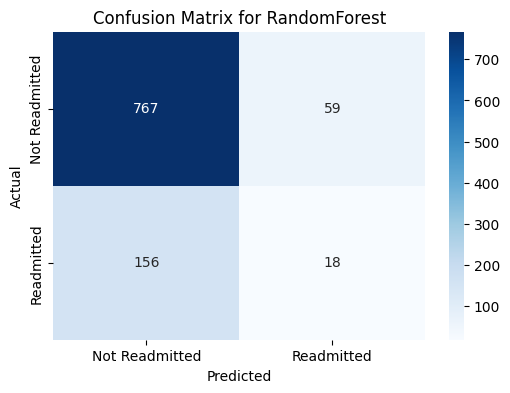

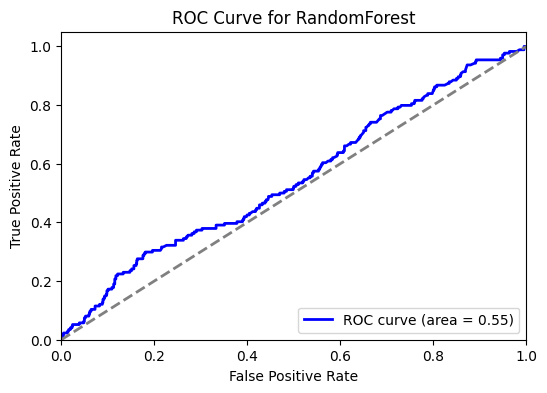


Model Performance for GradientBoosting:
Accuracy: 0.817
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       826
           1       0.38      0.09      0.14       174

    accuracy                           0.82      1000
   macro avg       0.61      0.53      0.52      1000
weighted avg       0.76      0.82      0.77      1000



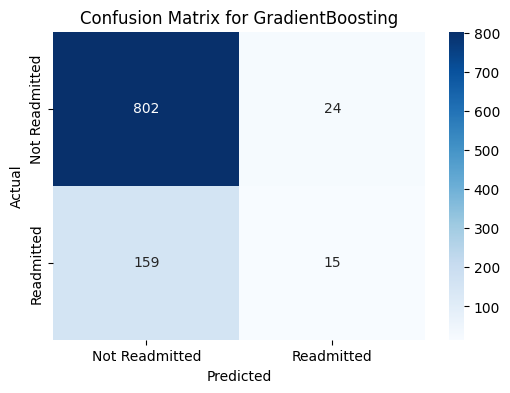

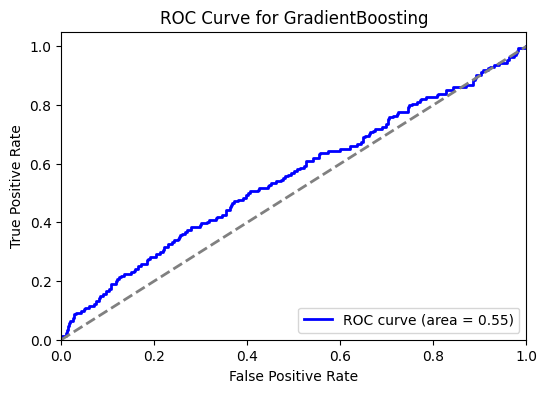


Model Performance for XGBoost:
Accuracy: 0.802
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       826
           1       0.26      0.07      0.12       174

    accuracy                           0.80      1000
   macro avg       0.55      0.51      0.50      1000
weighted avg       0.73      0.80      0.75      1000



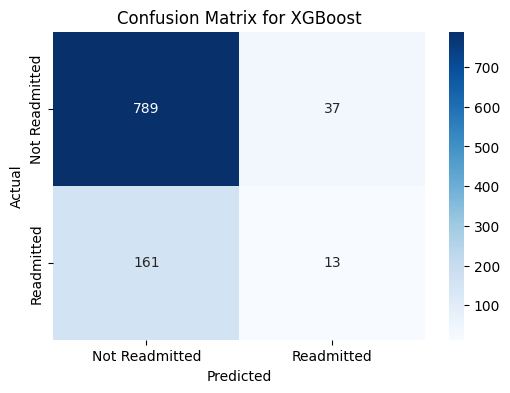

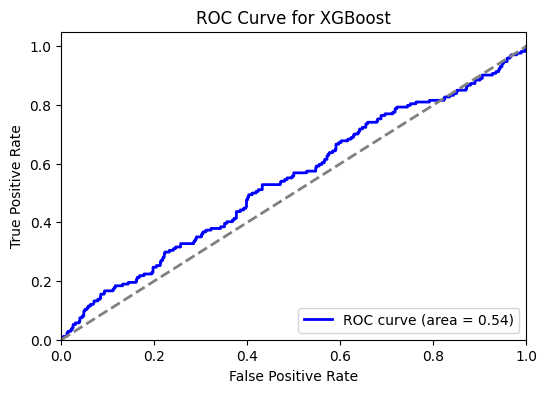

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import ADASYN
import os


# Feature Engineering
train_df['age_group'] = pd.cut(train_df['age'], bins=[0, 18, 35, 50, 65, 80, 100], labels=['0-18', '19-35', '36-50', '51-65', '66-80', '81-100'])
train_df['comorbidity_procedures'] = train_df['comorbidity_score'] * train_df['num_procedures']
train_df['comorbidity_days'] = train_df['comorbidity_score'] * train_df['days_in_hospital']
train_df['stay_length'] = pd.cut(train_df['days_in_hospital'], bins=[0, 3, 7, 14, 30, 100], labels=['0-3', '4-7', '8-14', '15-30', '31+'])
train_df['procedure_count'] = pd.cut(train_df['num_procedures'], bins=[0, 1, 3, 5, 10], labels=['0-1', '2-3', '4-5', '6+'])
train_df['gender_age'] = train_df['gender'].apply(lambda x: 1 if x == 'Male' else 0) * train_df['age']
train_df['diagnosis_comorbidity'] = train_df['primary_diagnosis'].apply(lambda x: hash(x) % 10) * train_df['comorbidity_score']

# Additional Interaction Terms
train_df['age_stay_length'] = train_df['age'] * train_df['days_in_hospital']
train_df['comorbidity_gender'] = train_df['comorbidity_score'] * train_df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
train_df['diagnosis_procedures'] = train_df['primary_diagnosis'].apply(lambda x: hash(x) % 10) * train_df['num_procedures']
train_df['age_comorbidity'] = train_df['age'] * train_df['comorbidity_score']
train_df['stay_procedures'] = train_df['days_in_hospital'] * train_df['num_procedures']

# One-hot encoding for categorical variables
categorical_features = ['gender', 'primary_diagnosis', 'discharge_to', 'age_group', 'stay_length', 'procedure_count']
train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)

# Prepare features and target
X = train_df.drop(columns=['readmitted'])
y = train_df['readmitted']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Define models to be tested
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# Define hyperparameters for Grid Search
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# Perform Grid Search for each model
best_models = {}
for model_name in models:
    if model_name == "RandomForest":
        grid_search = GridSearchCV(models[model_name], param_grid_rf, cv=3, scoring='accuracy')
    elif model_name == "GradientBoosting":
        grid_search = GridSearchCV(models[model_name], param_grid_gb, cv=3, scoring='accuracy')
    elif model_name == "XGBoost":
        grid_search = GridSearchCV(models[model_name], param_grid_xgb, cv=3, scoring='accuracy')
    
    grid_search.fit(X_resampled, y_resampled)
    best_models[model_name] = grid_search.best_estimator_

# Evaluate the best models on the validation set and visualize results
for model_name in best_models:
    y_pred = best_models[model_name].predict(X_val)
    
    # Print performance metrics
    print(f"\nModel Performance for {model_name}:")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Readmitted', 'Readmitted'], yticklabels=['Not Readmitted', 'Readmitted'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # ROC Curve and AUC Score
    y_pred_prob = best_models[model_name].predict_proba(X_val)[:,1]
    
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve for {model_name}")
    plt.legend(loc="lower right")
    plt.show()

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import ADASYN
import os


# Feature Engineering
train_df['age_group'] = pd.cut(train_df['age'], bins=[0, 18, 35, 50, 65, 80, 100], labels=['0-18', '19-35', '36-50', '51-65', '66-80', '81-100'])
train_df['comorbidity_procedures'] = train_df['comorbidity_score'] * train_df['num_procedures']
train_df['comorbidity_days'] = train_df['comorbidity_score'] * train_df['days_in_hospital']
train_df['stay_length'] = pd.cut(train_df['days_in_hospital'], bins=[0, 3, 7, 14, 30, 100], labels=['0-3', '4-7', '8-14', '15-30', '31+'])
train_df['procedure_count'] = pd.cut(train_df['num_procedures'], bins=[0, 1, 3, 5, 10], labels=['0-1', '2-3', '4-5', '6+'])
train_df['gender_age'] = train_df['gender'].apply(lambda x: 1 if x == 'Male' else 0) * train_df['age']
train_df['diagnosis_comorbidity'] = train_df['primary_diagnosis'].apply(lambda x: hash(x) % 10) * train_df['comorbidity_score']

# One-hot encoding for categorical variables
categorical_features = ['gender', 'primary_diagnosis', 'discharge_to', 'age_group', 'stay_length', 'procedure_count']
train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)

# Prepare features and target
X = train_df.drop(columns=['readmitted'])
y = train_df['readmitted']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_val)

# Evaluate the model
print("\nModel Performance with New Features and ADASYN:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


Model Performance with New Features and ADASYN:
Accuracy: 0.768
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       826
           1       0.23      0.14      0.17       174

    accuracy                           0.77      1000
   macro avg       0.53      0.52      0.52      1000
weighted avg       0.73      0.77      0.74      1000




Random Forest Model Performance:
Accuracy: 0.792
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       826
           1       0.13      0.03      0.05       174

    accuracy                           0.79      1000
   macro avg       0.48      0.49      0.47      1000
weighted avg       0.70      0.79      0.74      1000


Logistic Regression Model Performance:
Accuracy: 0.483
              precision    recall  f1-score   support

           0       0.79      0.51      0.62       826
           1       0.13      0.36      0.19       174

    accuracy                           0.48      1000
   macro avg       0.46      0.43      0.41      1000
weighted avg       0.68      0.48      0.55      1000



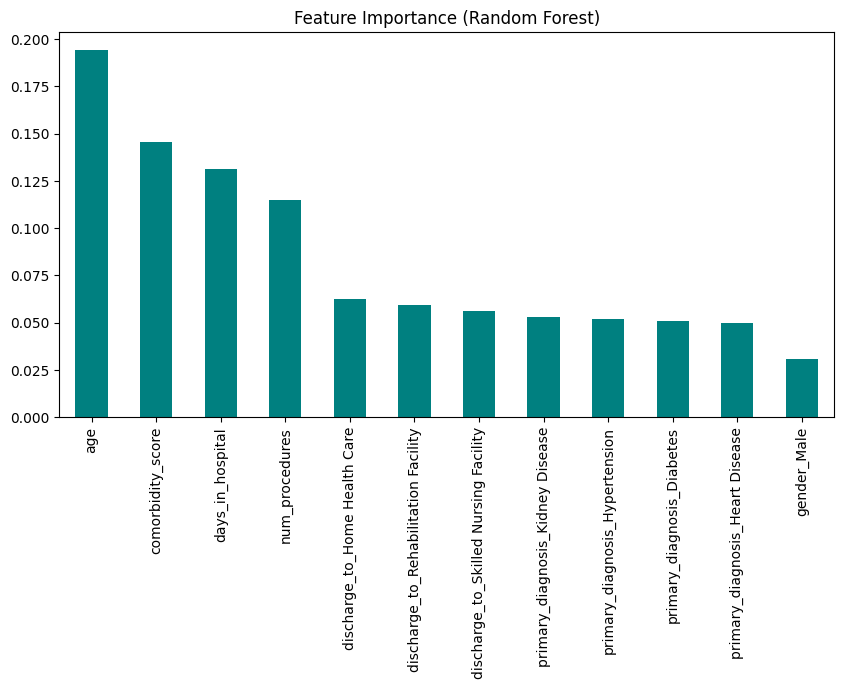

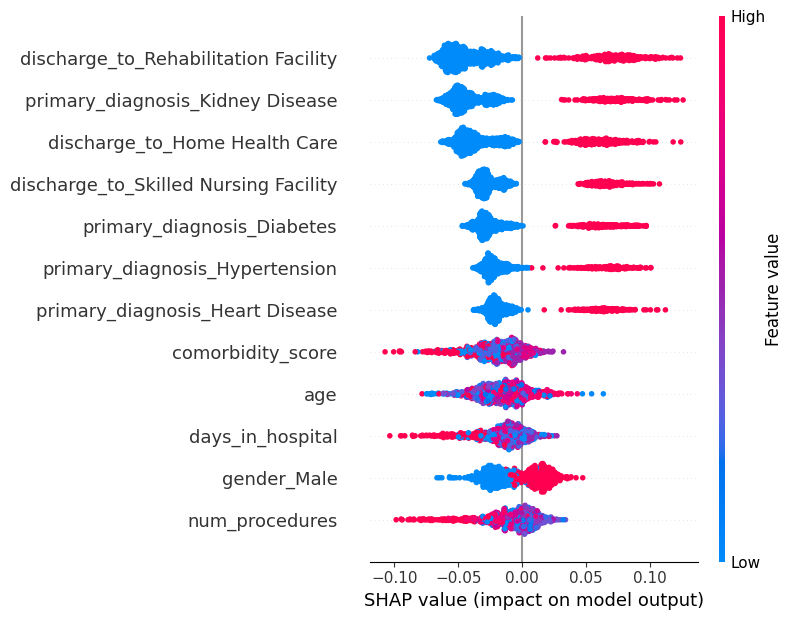

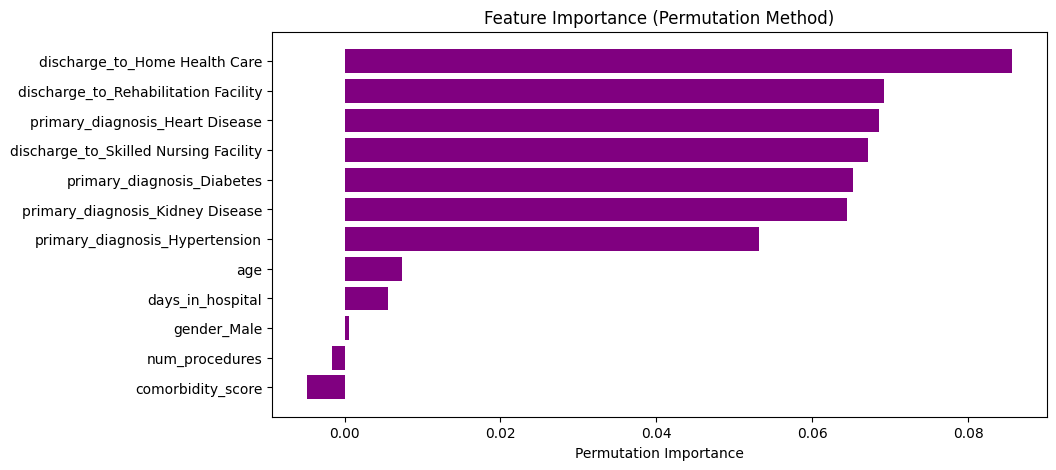

Point-Biserial Correlation: num_procedures vs readmission: -0.0027 (p-value: 0.8475)
Point-Biserial Correlation: days_in_hospital vs readmission: -0.0064 (p-value: 0.6502)


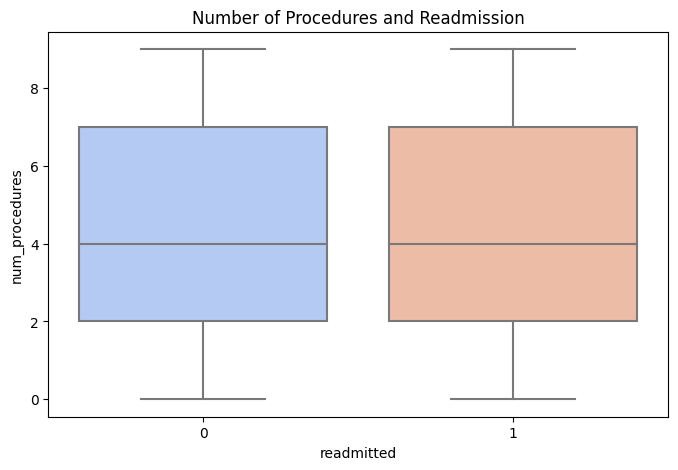

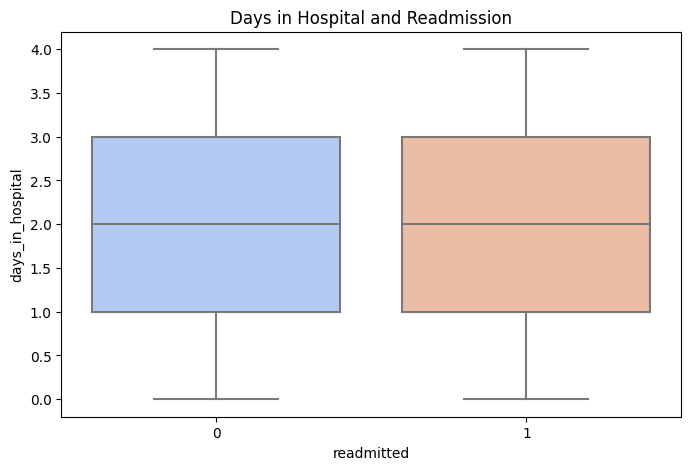

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.stats import pointbiserialr, kurtosis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.over_sampling import ADASYN
from sklearn.inspection import permutation_importance
import os

#KEY FINDINGS 

# Encode categorical variables
train_df = pd.get_dummies(train_df, drop_first=True)

# Feature Engineering: Binning numerical features
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
train_df[['days_in_hospital', 'comorbidity_score']] = binner.fit_transform(train_df[['days_in_hospital', 'comorbidity_score']])

# Handling Class Imbalance with ADASYN
X = train_df.drop(columns=['readmitted'])
y = train_df['readmitted']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

adasyn = ADASYN(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Hyperparameter tuning for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
rf_best = grid_search.best_estimator_

# Train and evaluate RandomForestClassifier
rf_best.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_best.predict(X_val)

print("\nRandom Forest Model Performance:")
print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))

# Logistic Regression as an alternative baseline
log_reg = LogisticRegression(max_iter=500, class_weight='balanced')
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_lr = log_reg.predict(X_val)

print("\nLogistic Regression Model Performance:")
print("Accuracy:", accuracy_score(y_val, y_pred_lr))
print(classification_report(y_val, y_pred_lr))

# Feature Importance using Random Forest
feature_importance = pd.Series(rf_best.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10,5), color='teal')
plt.title('Feature Importance (Random Forest)')
plt.show()

# SHAP Value Analysis
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values[1], X_val)

# Permutation Importance
perm_importance = permutation_importance(rf_best, X_val, y_val, scoring='accuracy')
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 5))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color='purple')
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation Method)")
plt.show()

# Correlation analysis for num_procedures and days_in_hospital
corr_proc, p_proc = pointbiserialr(train_df['num_procedures'], train_df['readmitted'])
corr_days, p_days = pointbiserialr(train_df['days_in_hospital'], train_df['readmitted'])
print(f"Point-Biserial Correlation: num_procedures vs readmission: {corr_proc:.4f} (p-value: {p_proc:.4f})")
print(f"Point-Biserial Correlation: days_in_hospital vs readmission: {corr_days:.4f} (p-value: {p_days:.4f})")

# Visualizing relationship
plt.figure(figsize=(8, 5))
sns.boxplot(x='readmitted', y='num_procedures', data=train_df, palette='coolwarm')
plt.title('Number of Procedures and Readmission')
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='readmitted', y='days_in_hospital', data=train_df, palette='coolwarm')
plt.title('Days in Hospital and Readmission')
plt.show()

In [11]:
#Modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import ADASYN
import os



# Feature Engineering
train_df['age_group'] = pd.cut(train_df['age'], bins=[0, 18, 35, 50, 65, 80, 100], labels=['0-18', '19-35', '36-50', '51-65', '66-80', '81-100'])
train_df['comorbidity_procedures'] = train_df['comorbidity_score'] * train_df['num_procedures']
train_df['comorbidity_days'] = train_df['comorbidity_score'] * train_df['days_in_hospital']
train_df['stay_length'] = pd.cut(train_df['days_in_hospital'], bins=[0, 3, 7, 14, 30, 100], labels=['0-3', '4-7', '8-14', '15-30', '31+'])
train_df['procedure_count'] = pd.cut(train_df['num_procedures'], bins=[0, 1, 3, 5, 10], labels=['0-1', '2-3', '4-5', '6+'])
train_df['gender_age'] = train_df['gender'].apply(lambda x: 1 if x == 'Male' else 0) * train_df['age']
train_df['diagnosis_comorbidity'] = train_df['primary_diagnosis'].apply(lambda x: hash(x) % 10) * train_df['comorbidity_score']

# Additional Interaction Terms
train_df['age_stay_length'] = train_df['age'] * train_df['days_in_hospital']
train_df['comorbidity_gender'] = train_df['comorbidity_score'] * train_df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
train_df['diagnosis_procedures'] = train_df['primary_diagnosis'].apply(lambda x: hash(x) % 10) * train_df['num_procedures']
train_df['age_comorbidity'] = train_df['age'] * train_df['comorbidity_score']
train_df['stay_procedures'] = train_df['days_in_hospital'] * train_df['num_procedures']

# One-hot encoding for categorical variables
categorical_features = ['gender', 'primary_diagnosis', 'discharge_to', 'age_group', 'stay_length', 'procedure_count']
train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)

# Prepare features and target
X = train_df.drop(columns=['readmitted'])
y = train_df['readmitted']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Define models to be tested
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# Define hyperparameters for Grid Search
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# Perform Grid Search for each model
best_models = {}
for model_name in models:
    if model_name == "RandomForest":
        grid_search = GridSearchCV(models[model_name], param_grid_rf, cv=3, scoring='accuracy')
    elif model_name == "GradientBoosting":
        grid_search = GridSearchCV(models[model_name], param_grid_gb, cv=3, scoring='accuracy')
    elif model_name == "XGBoost":
        grid_search = GridSearchCV(models[model_name], param_grid_xgb, cv=3, scoring='accuracy')
    
    grid_search.fit(X_resampled, y_resampled)
    best_models[model_name] = grid_search.best_estimator_

# Evaluate the best models on the validation set
for model_name in best_models:
    y_pred = best_models[model_name].predict(X_val)
    print(f"\nModel Performance for {model_name}:")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))


Model Performance for RandomForest:
Accuracy: 0.785
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       826
           1       0.23      0.10      0.14       174

    accuracy                           0.79      1000
   macro avg       0.53      0.52      0.51      1000
weighted avg       0.73      0.79      0.75      1000


Model Performance for GradientBoosting:
Accuracy: 0.817
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       826
           1       0.38      0.09      0.14       174

    accuracy                           0.82      1000
   macro avg       0.61      0.53      0.52      1000
weighted avg       0.76      0.82      0.77      1000


Model Performance for XGBoost:
Accuracy: 0.802
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       826
           1       0.26      0.07      0.12       174

    accuracy            

In [12]:
#Feature engineered model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import ADASYN
import os



# Feature Engineering
train_df['age_group'] = pd.cut(train_df['age'], bins=[0, 18, 35, 50, 65, 80, 100], labels=['0-18', '19-35', '36-50', '51-65', '66-80', '81-100'])
train_df['comorbidity_procedures'] = train_df['comorbidity_score'] * train_df['num_procedures']
train_df['comorbidity_days'] = train_df['comorbidity_score'] * train_df['days_in_hospital']
train_df['stay_length'] = pd.cut(train_df['days_in_hospital'], bins=[0, 3, 7, 14, 30, 100], labels=['0-3', '4-7', '8-14', '15-30', '31+'])
train_df['procedure_count'] = pd.cut(train_df['num_procedures'], bins=[0, 1, 3, 5, 10], labels=['0-1', '2-3', '4-5', '6+'])
train_df['gender_age'] = train_df['gender'].apply(lambda x: 1 if x == 'Male' else 0) * train_df['age']
train_df['diagnosis_comorbidity'] = train_df['primary_diagnosis'].apply(lambda x: hash(x) % 10) * train_df['comorbidity_score']

# Additional Interaction Terms
train_df['age_stay_length'] = train_df['age'] * train_df['days_in_hospital']
train_df['comorbidity_gender'] = train_df['comorbidity_score'] * train_df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
train_df['diagnosis_procedures'] = train_df['primary_diagnosis'].apply(lambda x: hash(x) % 10) * train_df['num_procedures']
train_df['age_comorbidity'] = train_df['age'] * train_df['comorbidity_score']
train_df['stay_procedures'] = train_df['days_in_hospital'] * train_df['num_procedures']

# One-hot encoding for categorical variables
categorical_features = ['gender', 'primary_diagnosis', 'discharge_to', 'age_group', 'stay_length', 'procedure_count']
train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)

# Prepare features and target
X = train_df.drop(columns=['readmitted'])
y = train_df['readmitted']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_val)

# Evaluate the model
print("\nModel Performance with Additional Interaction Terms and ADASYN:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


Model Performance with Additional Interaction Terms and ADASYN:
Accuracy: 0.787
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       826
           1       0.24      0.10      0.14       174

    accuracy                           0.79      1000
   macro avg       0.54      0.52      0.51      1000
weighted avg       0.73      0.79      0.75      1000



/kaggle/input/readmission-dataset/sample_submission.csv
/kaggle/input/readmission-dataset/train_df.csv
/kaggle/input/readmission-dataset/test_df.csv
Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                5000 non-null   int64 
 1   gender             5000 non-null   object
 2   primary_diagnosis  5000 non-null   object
 3   num_procedures     5000 non-null   int64 
 4   days_in_hospital   5000 non-null   int64 
 5   comorbidity_score  5000 non-null   int64 
 6   discharge_to       5000 non-null   object
 7   readmitted         5000 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 312.6+ KB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             -------

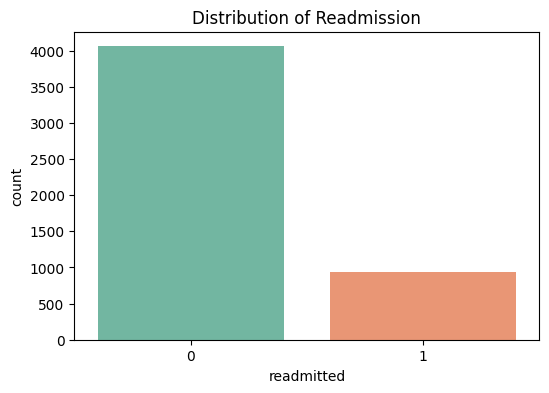

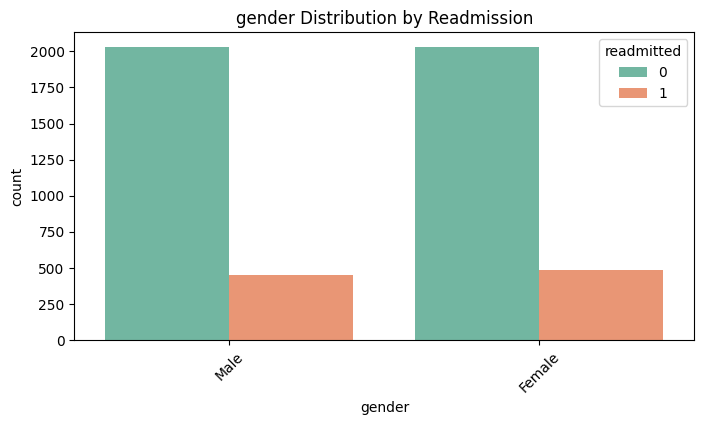

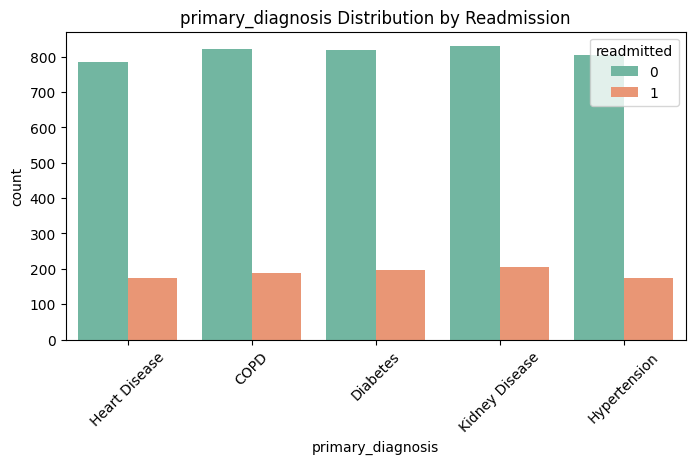

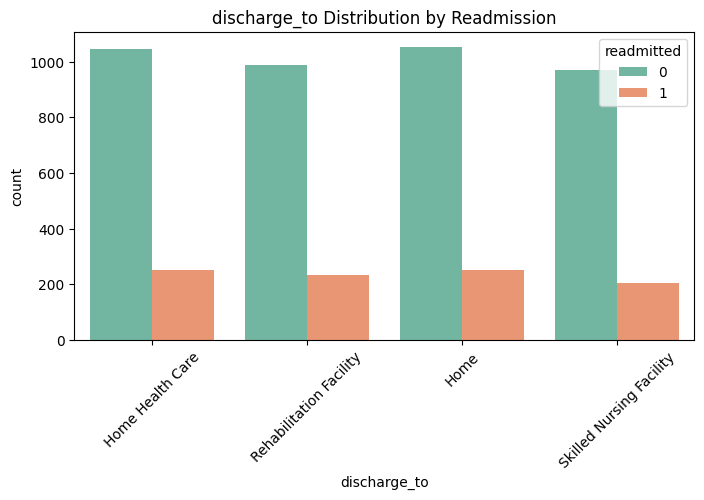

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


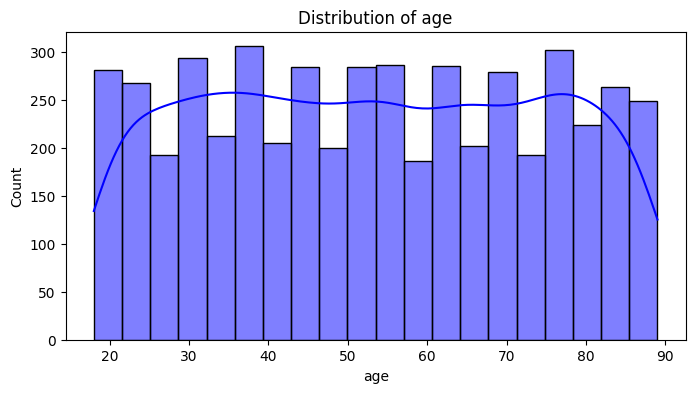

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


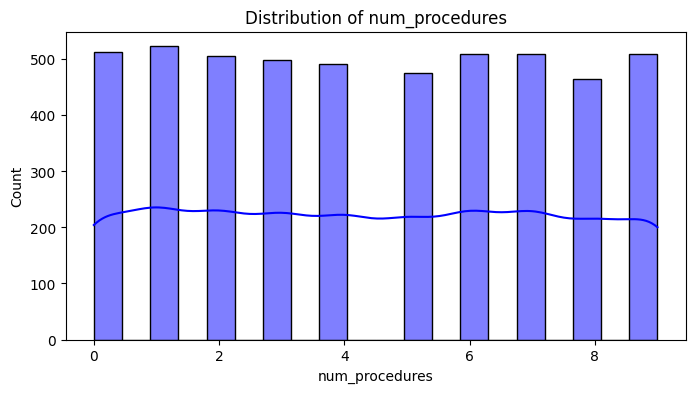

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


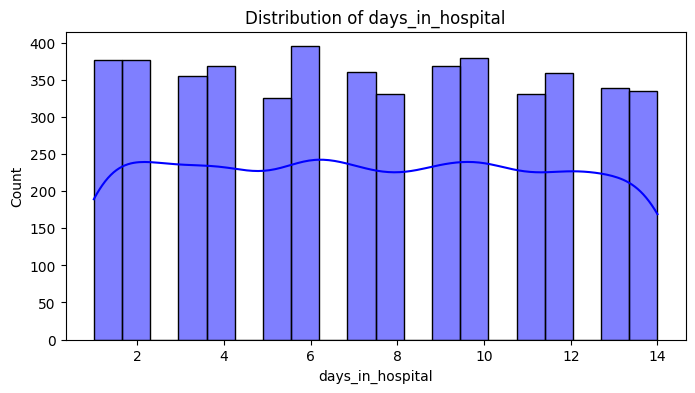

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


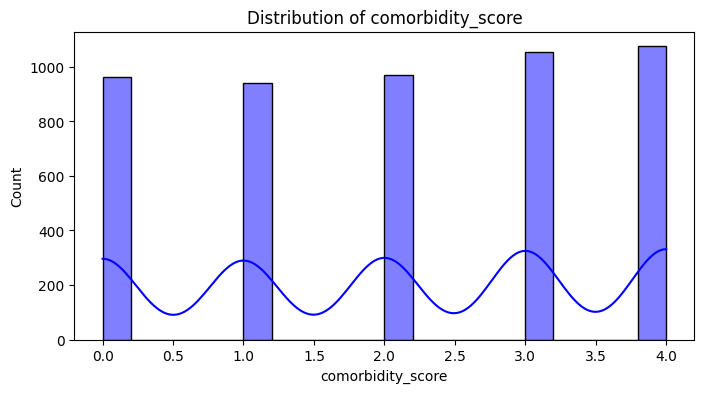

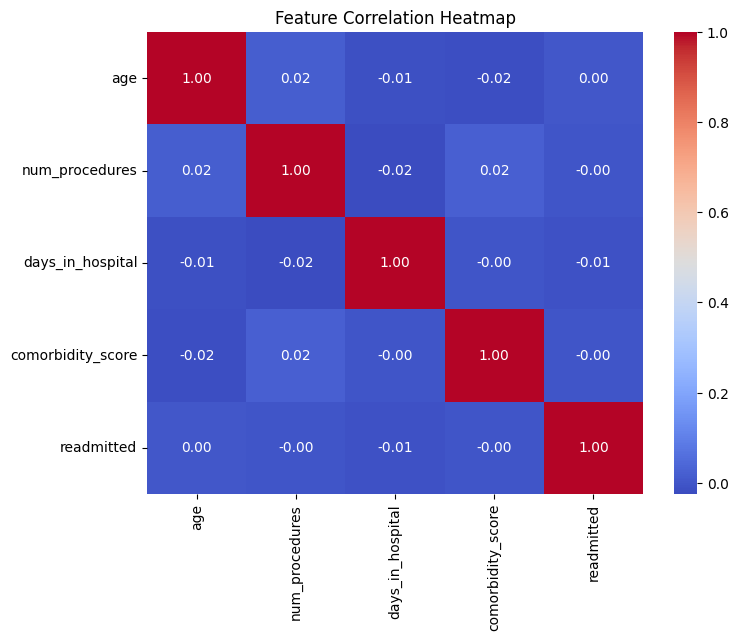

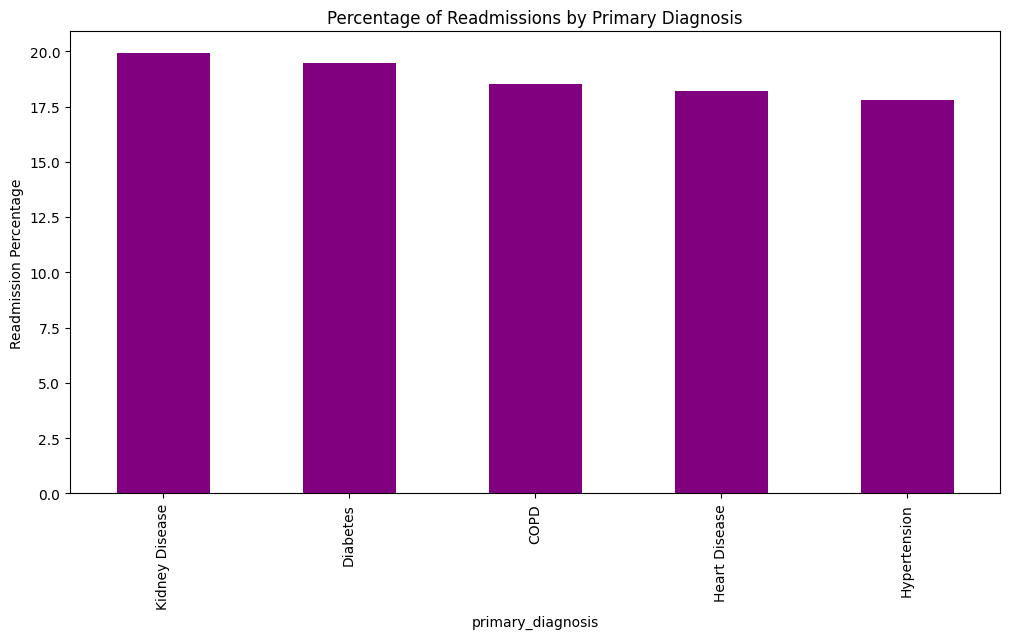


Kurtosis values for numerical features in the training dataset:
age                 -1.202006
num_procedures      -1.234990
days_in_hospital    -1.207308
comorbidity_score   -1.309918
dtype: float64

Baseline Model Performance with ADASYN:
Accuracy: 0.735
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       826
           1       0.22      0.20      0.21       174

    accuracy                           0.73      1000
   macro avg       0.53      0.52      0.52      1000
weighted avg       0.73      0.73      0.73      1000



In [9]:
#Visuals + basic stats + baseline model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import ADASYN
import os


categorical_features = ['gender', 'primary_diagnosis', 'discharge_to']
for feature in categorical_features:
    plot_categorical(feature)

# Visualizing numerical features
def plot_numerical(feature):
    plt.figure(figsize=(8,4))
    sns.histplot(train_df[feature], bins=20, kde=True, color='blue')
    plt.title(f"Distribution of {feature}")
    plt.show()

numerical_features = ['age', 'num_procedures', 'days_in_hospital', 'comorbidity_score']
for feature in numerical_features:
    plot_numerical(feature)

# Correlation heatmap
numeric_features = train_df.select_dtypes(include=[np.number])
plt.figure(figsize=(8,6))
sns.heatmap(numeric_features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Percentage of readmissions by primary diagnosis
readmission_pct = train_df.groupby('primary_diagnosis')['readmitted'].mean() * 100
plt.figure(figsize=(12,6))
readmission_pct.sort_values(ascending=False).plot(kind='bar', color='purple')
plt.title("Percentage of Readmissions by Primary Diagnosis")
plt.ylabel("Readmission Percentage")
plt.xticks(rotation=90)
plt.show()

# One-hot encoding for categorical variables
train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)

# Calculate kurtosis for numerical features
kurtosis_values = train_df[numerical_features].apply(kurtosis)
print("\nKurtosis values for numerical features in the training dataset:")
print(kurtosis_values)

# Prepare features and target
X = train_df.drop(columns=['readmitted'])
y = train_df['readmitted']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_val)

# Evaluate the model
print("\nBaseline Model Performance with ADASYN:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))